# Adversarial Noise for MNIST

### Introduction

上一章介绍了 adversarial examples 的例子通过加入 noise 来生成人眼无法区分的相似图片来欺骗神经网络，方法是传入原始图片，通过在 Inception model 中新加入 loss function 并计算对 noise 的 gradient 来调整针对原始图片的 noise 图片，也就是说得到的 noise 图片是 specialized for 输入图片的。

本章要在 MNIST 数据集上寻找几乎适合全部输入图片的 universial adversarial noise。剧透一下，由于这个特殊性，得到的 noise 会可以人眼识别，但是合成原始图片之后得到的混合图片仍然会被人眼鉴别为原始图片的分类，而不是 noise 的目标分类。

另外，我们还会找到方法来让神经网络对 adversarial noise 免疫，不受其影响。

### Flowchart

流程图中看到实例的原始图片为 7，而 noise 的目标分类为 3，我们看到其实 noise 图片可以被人眼识别为 3。noise 图片中的红色为 positive，让原始图片的对应区域加深，而蓝色为 negative，让原始图片对应区域变淡。看到合成后的混合图片，人眼还是能分辨出是 7，我们还可以看到一个暗色调的背景数字是 3

这个噪声会让神经网络把几乎所有 MNIST 图片识别为 3

我们首先不使用 noise 来正常的训练神经网络，得到类似上一节中的 Inception model (当然远比 Inception model 简单)；然后在得到的模型基础上去训练 noise 让神经网络对全部训练图片犯错

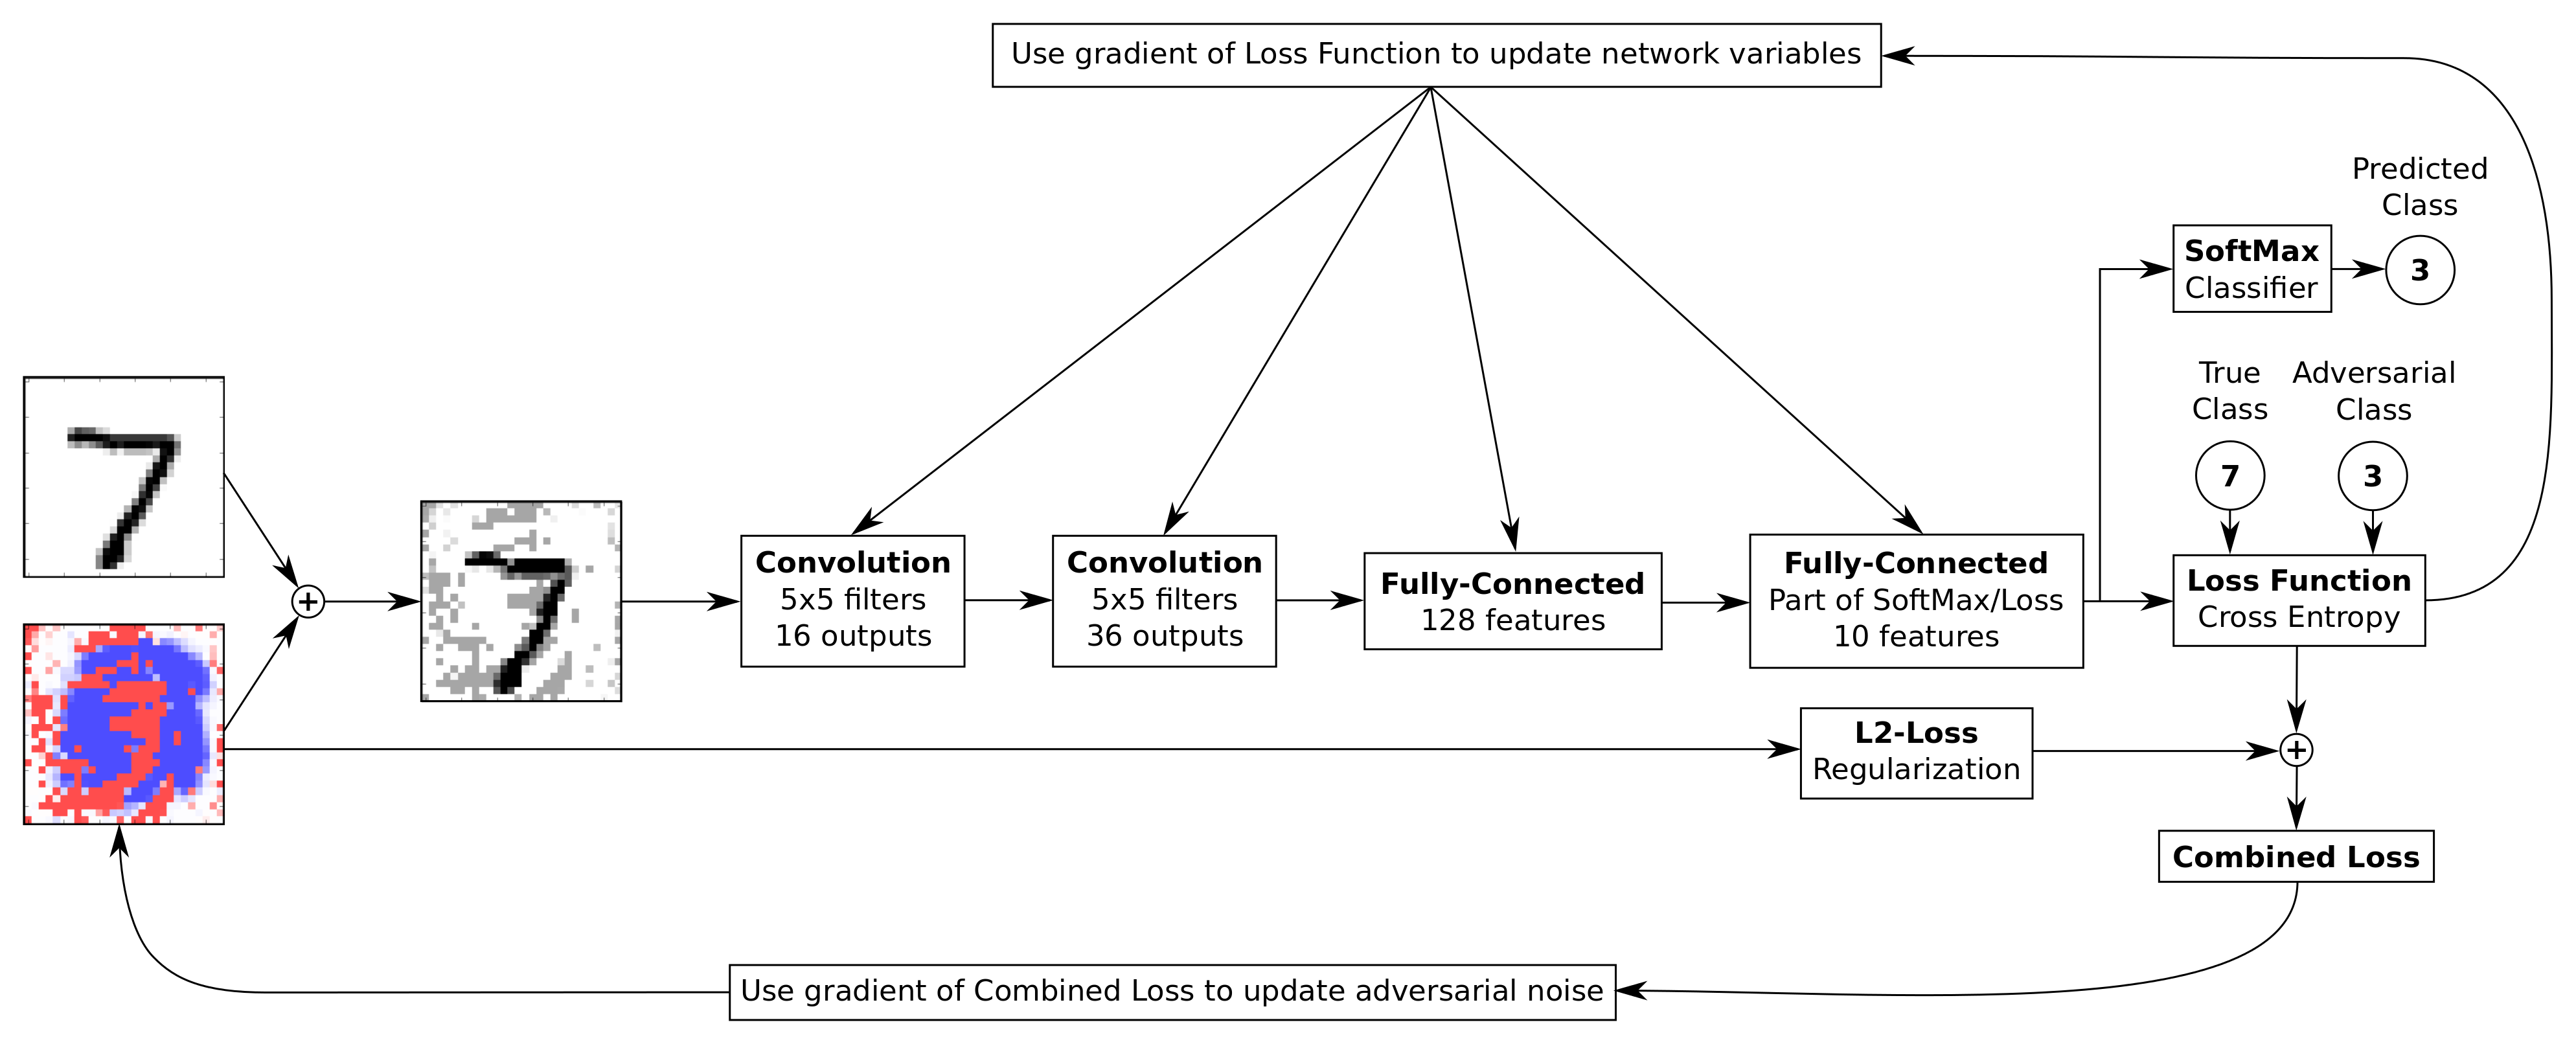

In [1]:
from IPython.display import Image
Image('images/12_adversarial_noise_flowchart.png')

### Imports

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix
import time
from datetime import timedelta
import math

# We also need PrettyTensor.
import prettytensor as pt

In [3]:
tf.__version__

'0.9.0'

### Load MNIST Data

In [4]:
from tensorflow.examples.tutorials.mnist import input_data
data = input_data.read_data_sets('data/MNIST/', one_hot=True)

Extracting data/MNIST/train-images-idx3-ubyte.gz
Extracting data/MNIST/train-labels-idx1-ubyte.gz
Extracting data/MNIST/t10k-images-idx3-ubyte.gz
Extracting data/MNIST/t10k-labels-idx1-ubyte.gz


In [5]:
print("Size of:")
print("- Training-set:\t\t{}".format(len(data.train.labels)))
print("- Test-set:\t\t{}".format(len(data.test.labels)))
print("- Validation-set:\t{}".format(len(data.validation.labels)))

Size of:
- Training-set:		55000
- Test-set:		10000
- Validation-set:	5000


In [6]:
data.test.cls = np.argmax(data.test.labels, axis=1)

In [7]:
img_size = 28
img_size_flat = img_size * img_size     # MNIST 图片实际上保存为一个矢量 28 x 28 长度
img_shape = (img_size, img_size)
num_channels = 1                        # 灰度图片
num_classes = 10

##### Helper-function for plotting images

In [8]:
def plot_images(images, cls_true, cls_pred=None, noise=0.0):    # 这里加入了 noise 参数，该参数默认为一个常数，其实可以是和图片一样维度的数组
    assert len(images) == len(cls_true) == 9
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        image = images[i].reshape(img_shape)     # 一维转二维
        image += noise                           # 加噪声
        image = np.clip(image, 0.0, 1.0)         # MNIST 数据集 pixel 为 0~1，防止加了噪声之后 overflow
        ax.imshow(image, cmap='binary', interpolation='nearest')

        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])
        ax.set_xlabel(xlabel)
        ax.set_xticks([])
        ax.set_yticks([])
        
    plt.show()

##### 尝试绘制

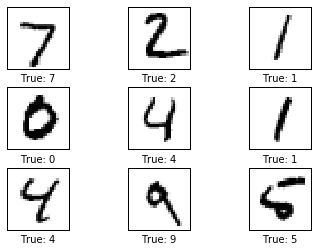

In [9]:
images = data.test.images[0:9]
cls_true = data.test.cls[0:9]
plot_images(images=images, cls_true=cls_true)

### TensorFlow Graph

##### Placeholder variables

In [10]:
x = tf.placeholder(tf.float32, shape=[None, img_size_flat], name='x')      # 一维的

In [11]:
x_image = tf.reshape(x, [-1, img_size, img_size, num_channels])            # 转 4 维，cnn 的 input

In [12]:
y_true = tf.placeholder(tf.float32, shape=[None, num_classes], name='y_true')

In [13]:
y_true_cls = tf.argmax(y_true, dimension=1)

##### Adversarial Noise

In [14]:
# MNIST 图片 pixel 为 0~1，故此我们不希望噪声太强，限制为正负 0.35 之间
noise_limit = 0.35

我们看到流程图中，还会对 noise 图片加上一个 l2 正则项，目的是让噪声值保持很小，不会再训练中变得过大

In [15]:
noise_l2_weight = 0.02

我们要训练 noise，故此要定义 noise 变量，而这个变量不是通常的 weight 或者 bias，故此需要我们通知 tensorflow 这个变量所属的 collection。这样才能在后续的 optimization 过程中找到合适的位置做优化

In [18]:
# 首先定义一个变量名
ADVERSARY_VARIABLES = 'adversary_variables'
# 然后加到 tf.GraphKeys.VARIABLES collections 中；然而要注意，加到这个 collections 中的变量会被初始化，然而不会被优化
collections = [tf.GraphKeys.VARIABLES, ADVERSARY_VARIABLES]

# 然后可以创建 noise 变量了，初始化为 0，如上所说，暂时不会在训练中被优化；不过这一点在第一阶段也就是不加噪声的正常训练阶段中是非常合适的
x_noise = tf.Variable(tf.zeros([img_size, img_size, num_channels]), name='x_noise', trainable=False, collections=collections)

施加 limit 限制

In [19]:
x_noise_clip = tf.assign(x_noise, tf.clip_by_value(x_noise, -noise_limit, noise_limit))

合成混合图片；不过这第一阶段正常训练中， x_noise_clip 是 0，故此就等同于原始图片；第二阶段会加入学习到的非零 noise 

In [20]:
x_noisy_image = x_image + x_noise

混合图片限制在 0，1之间

In [21]:
x_noisy_image = tf.clip_by_value(x_noisy_image, 0.0, 1.0)

##### Convolutional Neural Network

In [25]:
x_pretty = pt.wrap(x_noisy_image)

In [27]:
# 两个 conv 成后面都有 pooling，最后图片变为 7*7,36 channels
# 第一阶段正常训练，看到就是 conv + pooling + conv + pooling + flatten + fc + softmax
with pt.defaults_scope(activation_fn=tf.nn.relu):
    y_pred, loss = x_pretty.\
        conv2d(kernel=5, depth=16, name='layer_conv1').\
        max_pool(kernel=2, stride=2).\
        conv2d(kernel=5, depth=36, name='layer_conv2').\
        max_pool(kernel=2, stride=2).\
        flatten().\
        fully_connected(size=128, name='layer_fc1').\
        softmax_classifier(class_count=num_classes, labels=y_true)

我们应该看到，noise:0 应该不在 trainable variable 中

In [28]:
[var.name for var in tf.trainable_variables()]

[u'layer_conv1/weights:0',
 u'layer_conv1/bias:0',
 u'layer_conv2/weights:0',
 u'layer_conv2/bias:0',
 u'layer_fc1/weights:0',
 u'layer_fc1/bias:0',
 u'fully_connected/weights:0',
 u'fully_connected/bias:0']

In [29]:
# Adam 优化器
optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(loss)

##### 第二阶段对 Adversarial Noise 的优化方法

In [30]:
# 先从 collections 中取出变量
adversary_variables = tf.get_collection(ADVERSARY_VARIABLES)

显示变量名，这里我们发现了两个变量，显然第一个 x_noise:0 就对了

In [31]:
[var.name for var in adversary_variables]

[u'x_noise:0', u'x_noise_1:0']

l2 正则项及其 weight

In [32]:
l2_loss_noise = noise_l2_weight * tf.nn.l2_loss(x_noise)

那么，加入噪声 noise 之后的 loss 为  (loss 方面是让预测结果尽量接近目标分类，而 l2loss 方面是让 noise 值尽量小)

In [33]:
loss_adversary = loss + l2_loss_noise

In [35]:
# 第二阶段的优化目标是 loss_adversary，同时指定优化变量为 adversarial_variables，而不优化原来的 tf.trainable_variables(
optimizer_adversary = tf.train.AdamOptimizer(learning_rate=1e-2).minimize(loss_adversary, var_list=adversary_variables)

综上，我们构建了一套 cnn 神经网络，并设计了两套 loss function 和对应的优化器

##### Performance Measures

In [36]:
y_pred_cls = tf.argmax(y_pred, dimension=1)

In [37]:
correct_prediction = tf.equal(y_pred_cls, y_true_cls)

In [38]:
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

### TensorFlow Run

In [39]:
session = tf.Session()

In [40]:
session.run(tf.initialize_all_variables())

上面应该没有初始化 noise

In [41]:
def init_noise():
    session.run(tf.initialize_variables([x_noise]))

In [42]:
init_noise()

##### 训练流程

In [43]:
train_batch_size = 64

In [44]:
# 根据 adversary_target_cls 来区分是哪个阶段的训练
def optimize(num_iterations, adversary_target_cls=None):
    start_time = time.time()

    for i in range(num_iterations):
        x_batch, y_true_batch = data.train.next_batch(train_batch_size)
        if adversary_target_cls is not None:
            y_true_batch = np.zeros_like(y_true_batch)
            y_true_batch[:, adversary_target_cls] = 1.0
        feed_dict_train = {x: x_batch, y_true: y_true_batch}

        if adversary_target_cls is None:
            session.run(optimizer, feed_dict=feed_dict_train)
        else:
            session.run(optimizer_adversary, feed_dict=feed_dict_train)
            # 并 run 出 noise
            session.run(x_noise_clip)

        if (i % 100 == 0) or (i == num_iterations - 1):
            acc = session.run(accuracy, feed_dict=feed_dict_train)
            msg = "Optimization Iteration: {0:>6}, Training Accuracy: {1:>6.1%}"
            print(msg.format(i, acc))

    end_time = time.time()
    time_dif = end_time - start_time
    print("Time usage: " + str(timedelta(seconds=int(round(time_dif)))))

##### 绘制 noise 的辅助函数

In [45]:
def get_noise():
    noise = session.run(x_noise)
    return np.squeeze(noise)

In [46]:
def plot_noise():
    noise = get_noise()
    
    print("Noise:")
    print("- Min:", noise.min())
    print("- Max:", noise.max())
    print("- Std:", noise.std())

    plt.imshow(noise, interpolation='nearest', cmap='seismic', vmin=-1.0, vmax=1.0)

##### 其他辅助结果展示函数

In [47]:
def plot_example_errors(cls_pred, correct):
    incorrect = (correct == False)
    images = data.test.images[incorrect]
    cls_pred = cls_pred[incorrect]
    cls_true = data.test.cls[incorrect]

    noise = get_noise()
    
    plot_images(images=images[0:9], cls_true=cls_true[0:9], cls_pred=cls_pred[0:9], noise=noise)    # 注意，这里在展示时加入了 noise

In [48]:
def plot_confusion_matrix(cls_pred):
    cls_true = data.test.cls
    cm = confusion_matrix(y_true=cls_true, y_pred=cls_pred)
    print(cm)

##### 训练结果展示

In [49]:
# 测试集上的测试结果
test_batch_size = 256

def print_test_accuracy(show_example_errors=False, show_confusion_matrix=False):
    num_test = len(data.test.images)
    cls_pred = np.zeros(shape=num_test, dtype=np.int)

    i = 0
    while i < num_test:
        j = min(i + test_batch_size, num_test)
        images = data.test.images[i:j, :]
        labels = data.test.labels[i:j, :]
        feed_dict = {x: images, y_true: labels}
        cls_pred[i:j] = session.run(y_pred_cls, feed_dict=feed_dict)
        i = j

    cls_true = data.test.cls
    correct = (cls_true == cls_pred)
    correct_sum = correct.sum()
    acc = float(correct_sum) / num_test

    msg = "Accuracy on Test-Set: {0:.1%} ({1} / {2})"
    print(msg.format(acc, correct_sum, num_test))
    if show_example_errors:
        print("Example errors:")
        plot_example_errors(cls_pred=cls_pred, correct=correct)
    if show_confusion_matrix:
        print("Confusion Matrix:")
        plot_confusion_matrix(cls_pred=cls_pred)

##### 第一阶段训练

In [50]:
optimize(num_iterations=1000)

Optimization Iteration:      0, Training Accuracy:  14.1%
Optimization Iteration:    100, Training Accuracy:  93.8%
Optimization Iteration:    200, Training Accuracy:  90.6%
Optimization Iteration:    300, Training Accuracy:  89.1%
Optimization Iteration:    400, Training Accuracy:  90.6%
Optimization Iteration:    500, Training Accuracy:  92.2%
Optimization Iteration:    600, Training Accuracy:  95.3%
Optimization Iteration:    700, Training Accuracy:  96.9%
Optimization Iteration:    800, Training Accuracy:  92.2%
Optimization Iteration:    900, Training Accuracy:  98.4%
Optimization Iteration:    999, Training Accuracy:  96.9%
Time usage: 0:01:25


训练集上准确率基本达到 97%

Accuracy on Test-Set: 96.7% (9671 / 10000)
Example errors:


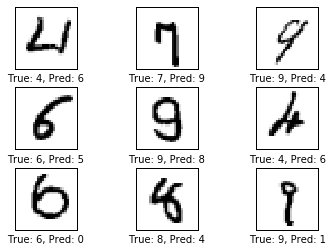

In [51]:
print_test_accuracy(show_example_errors=True)

测试集上准确率稍差一点点，96.7%

##### 第二阶段训练 noise

In [52]:
init_noise()   # 其实并不必要，前面已经初始化过了

In [53]:
optimize(num_iterations=1000, adversary_target_cls=3)  # 以 3 为目标优化

Optimization Iteration:      0, Training Accuracy:  14.1%
Optimization Iteration:    100, Training Accuracy: 100.0%
Optimization Iteration:    200, Training Accuracy:  98.4%
Optimization Iteration:    300, Training Accuracy:  98.4%
Optimization Iteration:    400, Training Accuracy:  93.8%
Optimization Iteration:    500, Training Accuracy:  96.9%
Optimization Iteration:    600, Training Accuracy:  98.4%
Optimization Iteration:    700, Training Accuracy:  98.4%
Optimization Iteration:    800, Training Accuracy:  96.9%
Optimization Iteration:    900, Training Accuracy: 100.0%
Optimization Iteration:    999, Training Accuracy:  95.3%
Time usage: 0:01:26


第二阶段的训练，cls_train_batch 已经被指定为目标分类 3；此时，训练集的准确率很高了，就是说大部分训练集图片被识别为 3 了。我们看看此刻的 noise 图，红色部分应该很像 3 了

Noise:
('- Min:', -0.34999999)
('- Max:', 0.34999999)
('- Std:', 0.19748853)


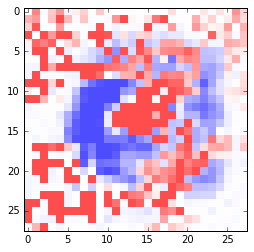

In [54]:
plot_noise()

此时在训练集上准确率只能达到 10% 左右，这是因为 print_test_accuracy 函数还是和原始分类的结果做对比，然而却被都分类为 3 ，故此准确率不高；其实看看下面的 cm 矩阵，就知道了，大部分图片确实都成功被识别为 3

Accuracy on Test-Set: 13.3% (1331 / 10000)
Example errors:


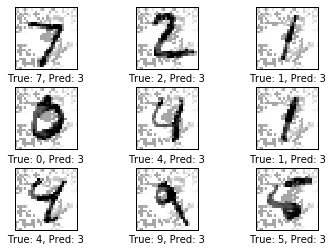

Confusion Matrix:
[[ 115    0    0  865    0    0    0    0    0    0]
 [   0    0    0 1135    0    0    0    0    0    0]
 [   0    0   83  949    0    0    0    0    0    0]
 [   0    0    0 1010    0    0    0    0    0    0]
 [   0    0    0  955   24    0    0    0    3    0]
 [   0    0    0  867    0   25    0    0    0    0]
 [   0    0    0  929    0    1   28    0    0    0]
 [   0    0    0 1004    0    0    0   24    0    0]
 [   0    0    0  952    0    0    0    0   22    0]
 [   0    0    0 1009    0    0    0    0    0    0]]


In [55]:
print_test_accuracy(show_example_errors=True,
                    show_confusion_matrix=True)

##### 辅助函数来对所有 1~9 分类都跑出对应的 adversarial noise 图片

In [56]:
def find_all_noise(num_iterations=1000):
    all_noise = []
    for i in range(num_classes):
        print("Finding adversarial noise for target-class:", i)
        init_noise()
        optimize(num_iterations=num_iterations, adversary_target_cls=i)
        noise = get_noise()
        all_noise.append(noise)

        # Print newline.
        print()
    return all_noise

In [58]:
all_noise = find_all_noise(num_iterations=300)

('Finding adversarial noise for target-class:', 0)
Optimization Iteration:      0, Training Accuracy:  10.9%
Optimization Iteration:    100, Training Accuracy:  71.9%
Optimization Iteration:    200, Training Accuracy:  87.5%
Optimization Iteration:    299, Training Accuracy:  85.9%
Time usage: 0:00:27
()
('Finding adversarial noise for target-class:', 1)
Optimization Iteration:      0, Training Accuracy:   9.4%
Optimization Iteration:    100, Training Accuracy:  42.2%
Optimization Iteration:    200, Training Accuracy:  50.0%
Optimization Iteration:    299, Training Accuracy:  54.7%
Time usage: 0:00:27
()
('Finding adversarial noise for target-class:', 2)
Optimization Iteration:      0, Training Accuracy:   7.8%
Optimization Iteration:    100, Training Accuracy:  98.4%
Optimization Iteration:    200, Training Accuracy:  98.4%
Optimization Iteration:    299, Training Accuracy:  98.4%
Time usage: 0:00:26
()
('Finding adversarial noise for target-class:', 3)
Optimization Iteration:      0,

##### 辅助函数来展示所有 1~9 分类对应的 adversarial noise 图片

In [59]:
def plot_all_noise(all_noise):    
    fig, axes = plt.subplots(2, 5)
    fig.subplots_adjust(hspace=0.2, wspace=0.1)

    for i, ax in enumerate(axes.flat):
        noise = all_noise[i]
        ax.imshow(noise, cmap='seismic', interpolation='nearest', vmin=-1.0, vmax=1.0)

        ax.set_xlabel(i)
        ax.set_xticks([])
        ax.set_yticks([])

    plt.show()

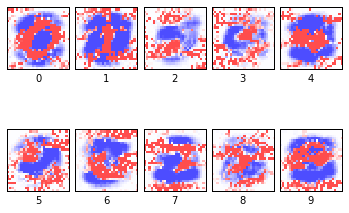

In [60]:
plot_all_noise(all_noise)

### 最后，让神经网络对 Adversarial Noise 免疫

方法是 re-training 神经网络来忽略 Adversial Noise

##### 训练网络对某个目标分类免疫

和之前的步骤正好相反，也分两步，首先训练网络来找到目标分类的 Adversarial noise，然后运行正常的训练来免疫这个 noise；由于第二步的训练中，noise 并没有被清零，也就是说实际上第二步是按照正常的训练流程来训练带着 noise 的训练集

In [61]:
def make_immune(target_cls, num_iterations_adversary=500, num_iterations_immune=200):
    print("Target-class:", target_cls)
    print("Finding adversarial noise ...")

    # 首先对目标分类来训练对应的 Adversarial Noise，我们知道这个步骤不会影响 weights 和 biases，只会调整 noise
    optimize(num_iterations=num_iterations_adversary, adversary_target_cls=target_cls)

    # Newline.
    print()
    # 打印测试集上准确率，同样会是 10% 左右，所以需要打印 cm 来确认是不是加入 noise 后，都预测为目标分类
    print_test_accuracy(show_example_errors=False, show_confusion_matrix=False)
    # Newline.
    print()

    print("Making the neural network immune to the noise ...")

    # 注意，此时不能调用 init_noise()，带着噪声来训练
    optimize(num_iterations=num_iterations_immune)

    # Newline.
    print()
    # Print classification accuracy.
    print_test_accuracy(show_example_errors=False, show_confusion_matrix=True)

##### 测试目标分类 3

In [62]:
make_immune(target_cls=3)

('Target-class:', 3)
Finding adversarial noise ...
Optimization Iteration:      0, Training Accuracy:   1.6%
Optimization Iteration:    100, Training Accuracy:  95.3%
Optimization Iteration:    200, Training Accuracy:  96.9%
Optimization Iteration:    300, Training Accuracy:  98.4%
Optimization Iteration:    400, Training Accuracy:  98.4%
Optimization Iteration:    499, Training Accuracy:  98.4%
Time usage: 0:00:45
()
Accuracy on Test-Set: 14.0% (1401 / 10000)
()
Making the neural network immune to the noise ...
Optimization Iteration:      0, Training Accuracy:  25.0%
Optimization Iteration:    100, Training Accuracy:  96.9%
Optimization Iteration:    199, Training Accuracy:  96.9%
Time usage: 0:00:17
()
Accuracy on Test-Set: 95.4% (9538 / 10000)
Confusion Matrix:
[[ 970    0    3    1    0    0    3    1    2    0]
 [   0 1125    4    2    1    0    2    0    1    0]
 [   9    1  990    5    5    1    1   10   10    0]
 [   4    3   18  944    0    9    1   12   13    6]
 [   0    2 

看到，带着 Adversarial Noise 做训练之后再测试，发现准确率达到 95.4%

同样的过程再来一次，相当于在刚刚训练的 immune 的模型下，再一次训练出新的 Adversarial noise，然后再一次带着新的 noise 做正常的训练来免疫

In [63]:
make_immune(target_cls=3)

('Target-class:', 3)
Finding adversarial noise ...
Optimization Iteration:      0, Training Accuracy:   6.2%
Optimization Iteration:    100, Training Accuracy:  28.1%
Optimization Iteration:    200, Training Accuracy:  40.6%
Optimization Iteration:    300, Training Accuracy:  34.4%
Optimization Iteration:    400, Training Accuracy:  45.3%
Optimization Iteration:    499, Training Accuracy:  35.9%
Time usage: 0:00:46
()
Accuracy on Test-Set: 67.7% (6768 / 10000)
()
Making the neural network immune to the noise ...
Optimization Iteration:      0, Training Accuracy:  57.8%
Optimization Iteration:    100, Training Accuracy:  96.9%
Optimization Iteration:    199, Training Accuracy:  95.3%
Time usage: 0:00:18
()
Accuracy on Test-Set: 95.0% (9504 / 10000)
Confusion Matrix:
[[ 966    0    4    3    0    0    4    1    2    0]
 [   0 1120    3    4    0    0    4    0    4    0]
 [   9    2  980   13    6    0    4    7   11    0]
 [   2    0   13  963    0    8    1    8   11    4]
 [   1    1 

准确率没有什么变化，基本上稳定了。

看一下此时的噪声

Noise:
('- Min:', -0.34999999)
('- Max:', 0.34999999)
('- Std:', 0.27181113)


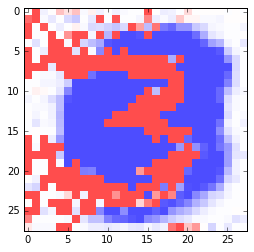

In [64]:
plot_noise()

看到，噪声仍然非常的明显，人眼很容易看到是 3；但是此时神经网络已经不会被这个 Noise 欺骗了

##### 对全部分类都免疫

In [67]:
def make_immune_all():
    for i in range(10):
        make_immune(target_cls=i)
    # 再上一次的基础上，再来一次
    for i in range(10):
        make_immune(target_cls=i)

In [68]:
make_immune_all()

('Target-class:', 0)
Finding adversarial noise ...
Optimization Iteration:      0, Training Accuracy:   7.8%
Optimization Iteration:    100, Training Accuracy:  65.6%
Optimization Iteration:    200, Training Accuracy:  71.9%
Optimization Iteration:    300, Training Accuracy:  82.8%
Optimization Iteration:    400, Training Accuracy:  81.2%
Optimization Iteration:    499, Training Accuracy:  84.4%
Time usage: 0:00:46
()
Accuracy on Test-Set: 27.2% (2715 / 10000)
()
Making the neural network immune to the noise ...
Optimization Iteration:      0, Training Accuracy:  39.1%
Optimization Iteration:    100, Training Accuracy:  96.9%
Optimization Iteration:    199, Training Accuracy:  95.3%
Time usage: 0:00:17
()
Accuracy on Test-Set: 95.5% (9555 / 10000)
Confusion Matrix:
[[ 969    0    0    2    1    0    3    2    3    0]
 [   1 1121    1    4    0    0    2    0    6    0]
 [   6    3  965   18    8    1    1   12   17    1]
 [   0    0    3  974    1    8    0   10   11    3]
 [   2    1 

看到，最后全免疫的模型在测试集(加噪声)上准确率达到 96.9 %

##### 使用此时的神经网络来训练未加噪声的原始测试集图片呢？

In [70]:
init_noise()

Accuracy on Test-Set: 92.5% (9246 / 10000)
Example errors:


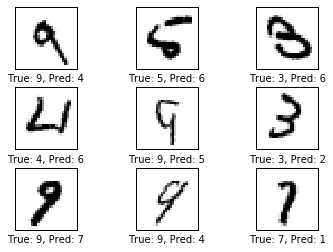

Confusion Matrix:
[[ 968    0    2    0    0    0   10    0    0    0]
 [   0 1125    4    0    0    0    6    0    0    0]
 [   5    2 1019    0    0    0    5    1    0    0]
 [   2    0   26  965    0    6    4    6    1    0]
 [   0    7    5    0  934    0   35    0    1    0]
 [   3    1    2    5    0  849   31    1    0    0]
 [   4    2    0    0    1    0  951    0    0    0]
 [   3   18   67    1    5    0    0  933    1    0]
 [  27   19   52    7    4    6   94    6  758    1]
 [  30   21   15   20  119   16    5   36    3  744]]


In [71]:
print_test_accuracy(show_example_errors=True, show_confusion_matrix=True)

相比之前纯粹从未加噪点的训练集训练得到的 96.7% 准确率来看，加入噪声训练来免疫之后，准确率有了一定下降

### Close TensorFlow Session

In [72]:
session.close()